In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# https://skyserver.sdss.org/dr9/en/tools/search/sql.asp 
# -- This query does a table JOIN between the imaging (PhotoObj) and spectra
# -- (SpecObj) tables and includes the necessary columns in the SELECT to upload
# -- the results to the SAS (Science Archive Server) for FITS file retrieval.
# SELECT TOP 10
#    p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
#    p.run, p.rerun, p.camcol, p.field,
#    s.specobjid, s.class, s.z as redshift,
#    s.plate, s.mjd, s.fiberid
# FROM PhotoObj AS p
#    JOIN SpecObj AS s ON s.bestobjid = p.objid
# WHERE 
#    p.u BETWEEN 0 AND 19.6
#    AND g BETWEEN 0 AND 20

In [3]:
star = pd.read_csv('data/stars_larger_2.csv',header=0)
star.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237645943434969150,40.279741,0.563509,18.41223,17.24312,17.35328,17.44520,17.54572,109,301,5,37,3519736912225083392,STAR,0.000315,3126,54804,632
1,1237645943435034680,40.384888,0.437542,23.95274,21.32203,19.64270,18.06598,17.26149,109,301,5,38,459520849293109248,STAR,-0.000079,408,51821,559
2,1237648703506285128,190.138527,-0.815252,26.10609,22.13030,20.31503,19.46180,19.07092,752,301,2,311,4333704553519576064,GALAXY,0.457345,3849,55274,421
3,1237648702967644418,186.099244,-1.085694,21.09884,20.30471,20.03852,20.03303,20.20160,752,301,1,284,2891344840430217216,STAR,0.001104,2568,54153,123
4,1237648702967644300,186.114326,-1.078596,20.06134,19.06786,18.90531,18.83770,18.90073,752,301,1,284,2891344290674403328,STAR,0.000619,2568,54153,121


In [4]:
star.shape

(2206175, 18)

In [5]:
star["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in star["class"]]

In [6]:
star['class'].value_counts(normalize=True)

0    0.609363
1    0.286573
2    0.104064
Name: class, dtype: float64

The classes are highly imbalanced with a lot more galaxies, 61%, than quasars, 10%. Quasars occur around galactic black holes that are actively eating and can be brighter than the billions of stars' of a galaxies light combined

In [7]:
star.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [8]:
# Function to convert MJD to datetime
def mjd_to_date(mjd):
    # Reference date for MJD (November 17, 1858)
    ref_date = datetime(1858, 11, 17)
    # Calculate the number of days from the reference date
    days = timedelta(days=mjd)
    # Add the number of days to the reference date
    date = ref_date + days
    # Return the date in MM-DD-YYYY format
    return date.strftime('%m-%d-%Y')
star['date'] = star['mjd'].apply(mjd_to_date)
star.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
0,1237645943434969150,40.279741,0.563509,18.41223,17.24312,17.35328,17.44520,17.54572,109,301,5,37,3519736912225083392,1,0.000315,3126,54804,632,12-04-2008
1,1237645943435034680,40.384888,0.437542,23.95274,21.32203,19.64270,18.06598,17.26149,109,301,5,38,459520849293109248,1,-0.000079,408,51821,559,10-04-2000
2,1237648703506285128,190.138527,-0.815252,26.10609,22.13030,20.31503,19.46180,19.07092,752,301,2,311,4333704553519576064,0,0.457345,3849,55274,421,03-19-2010
3,1237648702967644418,186.099244,-1.085694,21.09884,20.30471,20.03852,20.03303,20.20160,752,301,1,284,2891344840430217216,1,0.001104,2568,54153,123,02-22-2007
4,1237648702967644300,186.114326,-1.078596,20.06134,19.06786,18.90531,18.83770,18.90073,752,301,1,284,2891344290674403328,1,0.000619,2568,54153,121,02-22-2007


In [9]:
# what objects have the likely sensor readings for the five wavelengths?
star[(star['u']<0) | (star['g']<0) | (star['r']<0) | (star['i']<0) | (star['z']<0)].sample(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
3710,1237648703509692420,197.844867,-0.625637,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,752,301,2,363,3266286560210872320,1,-0.000161,2901,54652,185,07-05-2008
24928,1237648704586645733,205.316526,0.215253,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,752,301,4,412,336776041576032256,0,0.252570,299,51671,480,05-07-2000
34589,1237648702973935753,200.480380,-1.044931,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,752,301,1,380,3723373890177703936,1,0.000297,3307,54970,83,05-19-2009
766182,1237657585493279004,54.406031,-0.415885,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,2820,301,2,229,468447234275436544,2,1.176584,416,51811,265,09-24-2000
39437,1237648703512117332,203.387074,-0.623954,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,752,301,2,400,335570156962998272,0,0.145082,298,51955,189,02-15-2001


## Taking a look at image of 1237648702973673741 resulted in my discovery of the flags:
![flagged galaxy closer look.png](<attachment:flagged galaxy closer look.png>)
* **TOO_FEW_GOOD_DETECTIONS**
* **BINNED1** - Possible means data points are grouped together to attempt to improve the quality
* **INTERP** - Interpolation of some points may mean spectra is incomplete
* **NOPETRO** - Petrosian Magnitudes? "For galaxy photometry, measuring flux is more difficult than for stars, because galaxies do not all have the same radial surface brightness profile, and have no sharp edges. In order to avoid biases, we wish to measure a constant fraction of the total light, independent of the position and distance of the object....In practice, there are a number of complications associated with this definition, because noise, substructure, and the finite size of objects can cause objects to have no Petrosian radius, or more than one."
* **EDGE** - Objects near the edge of a survey are unreliable due to various observational biasis

## and Quasar 1237657585493606729:
* **STATIONARY**
* **TOO_FEW_DETECTIONS**
* **NODEBLEND_MOVING**
* **MOVED**
* **BINNED1**
* **MANYPETRO** 
* **NOPETRO**
* **EDGE**
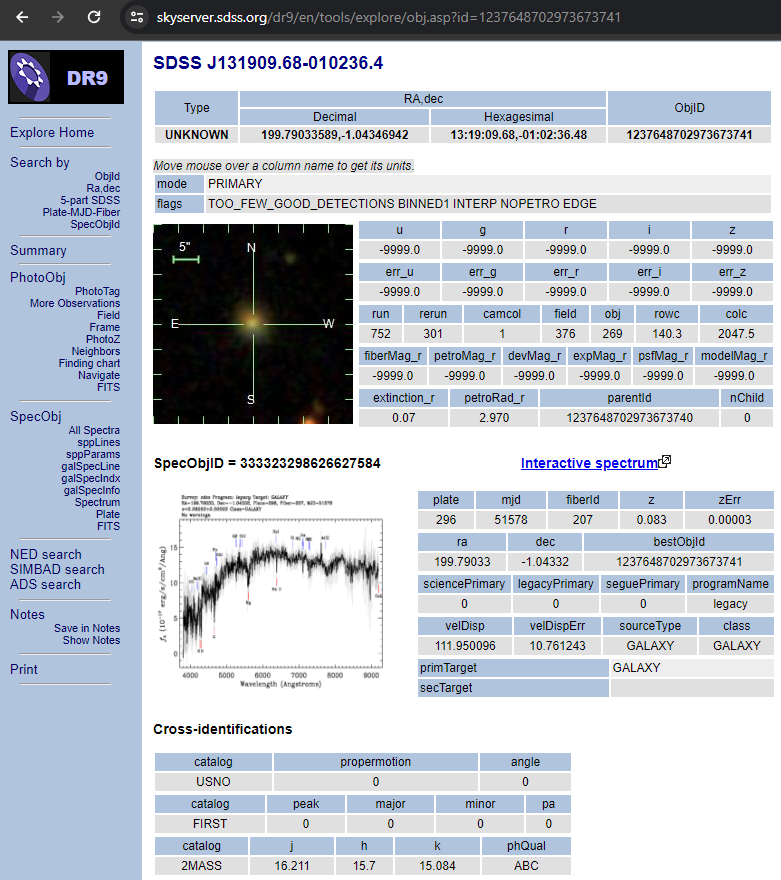

In [10]:
# how many uplicate ids are there? and what are the objects? and are they indentical?
#which ids are duplicated?
# star['objid'].duplicated().sum()
# if i sort the duplicates and look at quasars only, are they identical?

star[star['objid'].duplicated(keep=False)].sort_values('objid').shape


(102, 19)

### 51 duplicates - 4 seemed to change class after a more recent observation

In [11]:
# this one here: 1237651540315930774 is a quasar that later was observed and classified to be a galaxy
star[star['objid']==1237651540315930774]

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
145707,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,548405371329341440,2,0.139731,487,51943,335,02-03-2001
214316,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,2013112132052215808,0,0.139041,1788,54468,11,01-03-2008


#### the above object can also be examined more closely via SDSS skyserver
#### initially this was a Quasar
![QSO to Galaxy closer look 2.png](<attachment:QSO to Galaxy closer look 2.png>)
###### FLAGS: DEBLEND_DEGENERATE DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP COSMIC_RAY CHILD
#### The Same object is later a Galaxy
![QSO to Galaxy closer look 1.png](<attachment:QSO to Galaxy closer look 1.png>)
###### FLAGS: DEBLEND_DEGENERATE DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP COSMIC_RAY CHILD
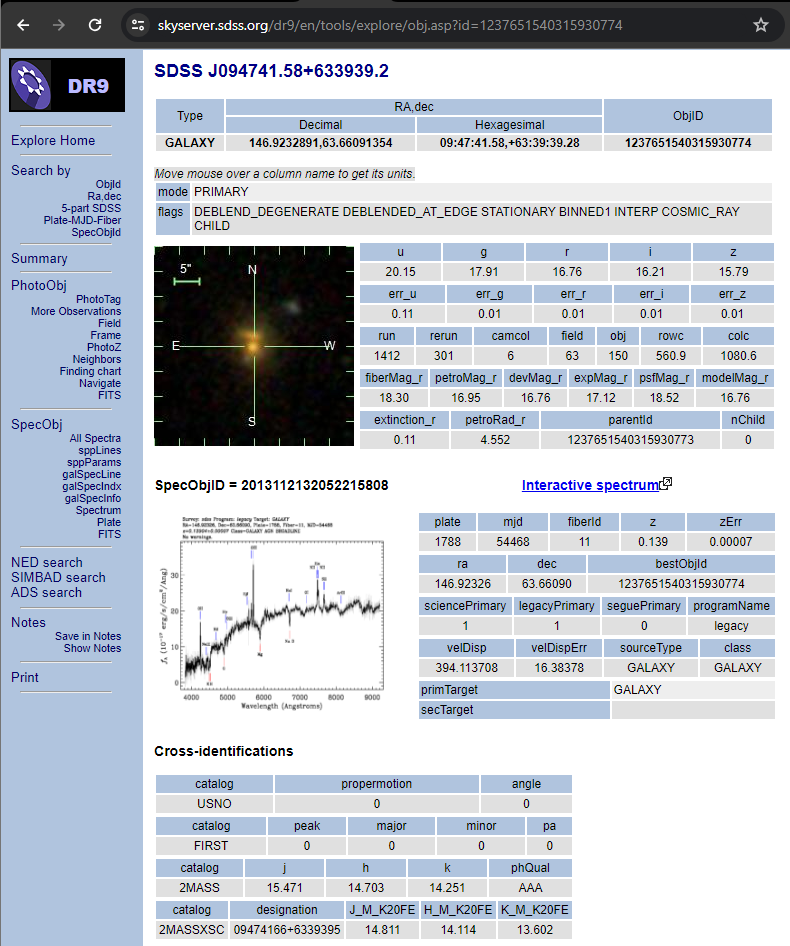
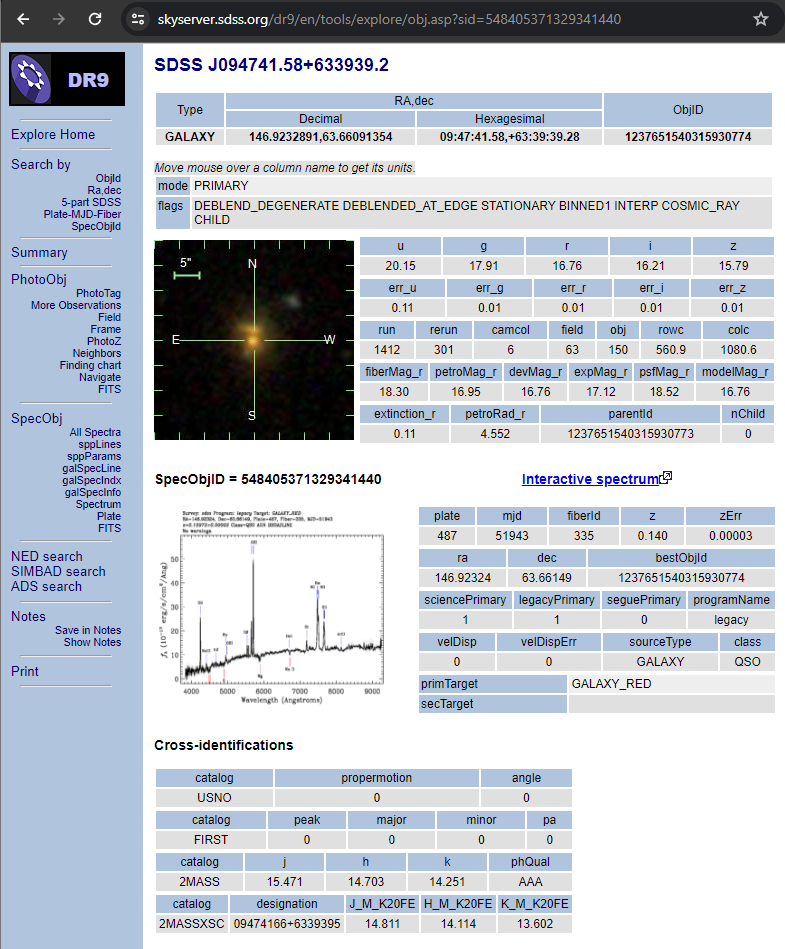

In [12]:
# did any other duplicated obj id change class?
duplicated_objects = star[star['objid'].duplicated(keep=False)]
# duplicated_objects.sort_values(['objid','mjd','class'])
class_changed = duplicated_objects[duplicated_objects.groupby('objid')['class'].transform('nunique') > 1]
class_changed.sort_values(['objid','mjd'])


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
145707,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,548405371329341440,2,0.139731,487,51943,335,02-03-2001
214316,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,2013112132052215808,0,0.139041,1788,54468,11,01-03-2008
545336,1237658424624677935,153.268087,7.180763,25.18145,25.14244,23.54615,20.51345,18.62344,3015,301,5,262,1121564027047143424,1,-0.000108,996,52641,610,01-02-2003
799411,1237658424624677935,153.268087,7.180763,25.18145,25.14244,23.54615,20.51345,18.62344,3015,301,5,262,5489032620962935808,2,0.429574,4875,55677,984,04-26-2011
1257808,1237661852022472838,232.243609,35.029149,20.56634,18.09183,16.82528,16.25343,15.87566,3813,301,5,474,1524630149285308416,1,-0.000178,1354,52814,588,06-24-2003
835854,1237661852022472838,232.243609,35.029149,20.56634,18.09183,16.82528,16.25343,15.87566,3813,301,5,474,1577468010728286208,0,0.194904,1401,53144,299,05-19-2004
1209568,1237666301628711158,48.860987,0.825905,23.14047,22.98053,23.05058,20.94145,20.93315,4849,301,5,781,1200379218676967424,1,-0.000586,1066,52589,618,11-11-2002
1184842,1237666301628711158,48.860987,0.825905,23.14047,22.98053,23.05058,20.94145,20.93315,4849,301,5,781,1705830767034132480,0,0.683108,1515,52932,336,10-20-2003


In [13]:
# 1237651540315930774 (MJD 51943 is 02-03-2001 and MJD 54468 is 01-03-2008)
# 1237658424624677935 has a similar time span between changing class. 
# Did the paradigm shift or did the quasar event come to an end?
# star[(star['objid']==1237651540315930774) | (star['objid']==1237658424624677935)] 
# redshift is the only meaningful difference between the two classifications for this subset
# depending on the nature of the 'objid' my approach to this can have unintended concequences. 
# I think I should take the more recent classification as the truth if data integrity is my concern. 

In [14]:
# negative values indicate errors in the sensor, i believe 
star = star[star['z']>0]
star = star[star['i']>0]
star = star[star['r']>0]
star = star[star['g']>0]
star = star[star['u']>0]
star.shape

(2206027, 19)

In [ ]:
qso_df = star[star['class']==2]
star_df = star[star['class']==1]
galaxy_df = star[star['class']==0]

In [ ]:
qso_df.shape , star_df.shape, galaxy_df.shape

((229564, 10), (632176, 10), (1344287, 10))

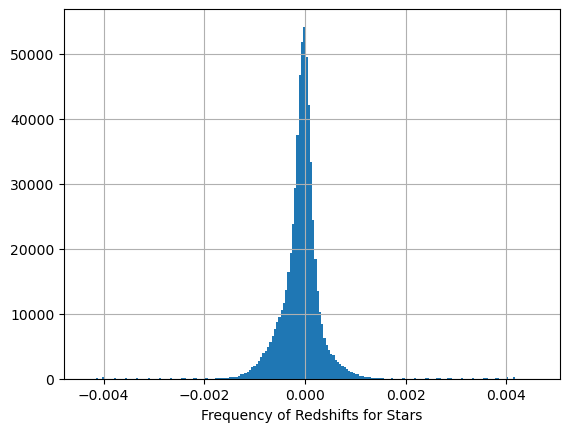

In [ ]:
star_df.redshift.hist(bins=200)
plt.xlabel('Redshifts for Stars')
plt.ylabel('Frequency')
plt.savefig('imgs/star_redshifts.png');

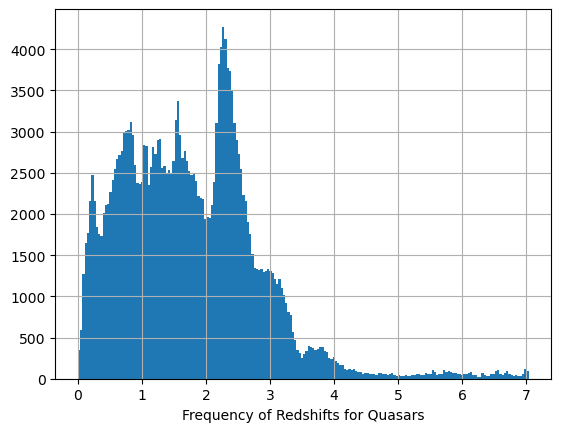

In [ ]:
qso_df.redshift.hist(bins=200)
plt.xlabel('Redshifts for Quasars')
plt.ylabel('Frequency')
plt.savefig('imgs/quasar_redshifts.png');

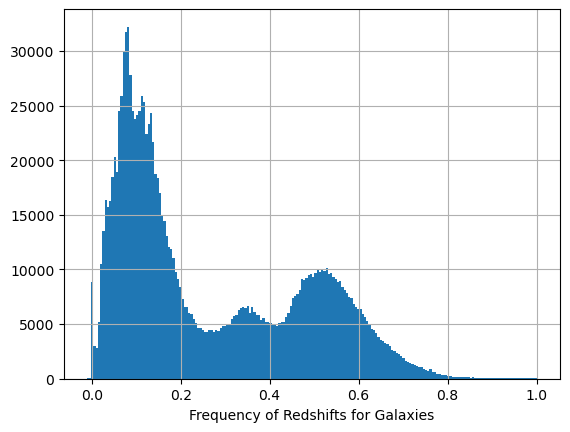

In [ ]:
galaxy_df.redshift.hist(bins=200)
plt.xlabel('Redshifts for Galaxies')
plt.ylabel('Frequency')
plt.savefig('imgs/galaxy_redshifts.png');

In [21]:
# Rando Forest 1: 

In [ ]:
# X = star.drop(columns=['class'])
# y = star['class']
# #train test split
# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=512)
# sm = SMOTE(random_state=512)
# print('Original dataset shape %s' % Counter(y_train))
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_train))

In [2]:
# rf =RandomForestClassifier(bootstrap=False)
# rf.fit(X_train,y_train)
# rf.score(X_test,y_test)

In [1]:
# print(classification_report(y_test, rf.predict(X_test)))

In [3]:
# print(confusion_matrix(y_test, rf.predict(X_test)))

### The random forrest model with only spectral info

In [28]:
star_spect_df = star[['objid','u','g','r','i','z','class','redshift']]

In [29]:
star_spect_df.head()

,u,g,r,i,z,class,redshift
0,18.41223,17.24312,17.35328,17.44520,17.54572,1,0.000315
1,23.95274,21.32203,19.64270,18.06598,17.26149,1,-0.000079
2,26.10609,22.13030,20.31503,19.46180,19.07092,0,0.457345
3,21.09884,20.30471,20.03852,20.03303,20.20160,1,0.001104
4,20.06134,19.06786,18.90531,18.83770,18.90073,1,0.000619


In [30]:
star_spect_df.describe()

,u,g,r,i,z,class,redshift
count,2.206027e+06,2.206027e+06,2.206027e+06,2.206027e+06,2.206027e+06,2.206027e+06,2.206027e+06
mean,2.109400e+01,1.945506e+01,1.850512e+01,1.801609e+01,1.773322e+01,4.946920e-01,3.462327e-01
std,2.312789e+00,1.999668e+00,1.758845e+00,1.646010e+00,1.640721e+00,6.768282e-01,6.260178e-01
min,7.920704e+00,7.468691e+00,8.454112e+00,7.652076e+00,6.485412e+00,0.000000e+00,-1.144670e-02
25%,1.938178e+01,1.799989e+01,1.723327e+01,1.683192e+01,1.655018e+01,0.000000e+00,2.026129e-04
50%,2.057454e+01,1.906009e+01,1.829337e+01,1.788934e+01,1.761104e+01,0.000000e+00,1.197853e-01
75%,2.281437e+01,2.118239e+01,2.007009e+01,1.935622e+01,1.899007e+01,1.000000e+00,4.587641e-01
max,3.277518e+01,3.373358e+01,3.384100e+01,3.210353e+01,3.084603e+01,2.000000e+00,7.037112e+00


In [31]:
Xs = star_spect_df.drop(columns=['class','objid'])
ys = star_spect_df['class']

In [32]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,ys,random_state=512)

In [33]:
sm2 = SMOTE(random_state=512)
print('Original dataset shape %s' % Counter(ys_train))
Xs_train, ys_train = sm2.fit_resample(Xs_train, ys_train)
print('Resampled dataset shape %s' % Counter(ys_train))

Original dataset shape Counter({0: 1008211, 1: 474017, 2: 172292})
Resampled dataset shape Counter({0: 1008211, 1: 1008211, 2: 1008211})


In [34]:
rf1 =RandomForestClassifier(bootstrap=False)
rf1.fit(Xs_train,ys_train)

RandomForestClassifier(bootstrap=False)

In [35]:
rf1.score(Xs_test,ys_test)

0.9891551693813496

In [36]:
print(classification_report(ys_test, rf1.predict(Xs_test)))
print(confusion_matrix(ys_test, rf1.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    336076
           1       1.00      1.00      1.00    158159
           2       0.96      0.95      0.95     57272

    accuracy                           0.99    551507
   macro avg       0.98      0.98      0.98    551507
weighted avg       0.99      0.99      0.99    551507

[[332984    744   2348]
 [    71 158083      5]
 [  2791     22  54459]]


In [37]:
sorted([(rf1.feature_importances_[i], rf1.feature_names_in_[i]) for i in range(len(rf1.feature_names_in_))])

[(0.03829644581014255, 'r'),
 (0.06198384387244379, 'g'),
 (0.06697504331415632, 'i'),
 (0.07333718891780225, 'u'),
 (0.09867655912904702, 'z'),
 (0.6607309189564081, 'redshift')]

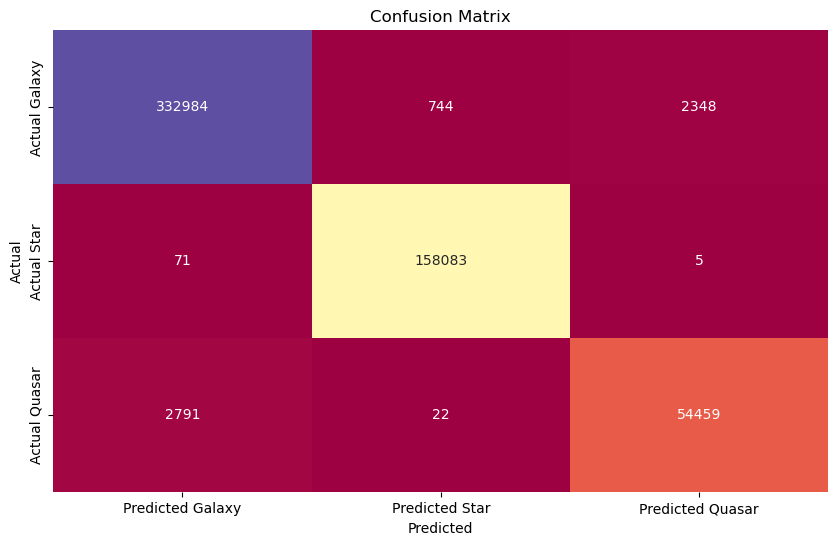

In [38]:
cm = confusion_matrix(ys_test, rf1.predict(Xs_test))

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False,
            xticklabels=["Predicted Galaxy", "Predicted Star","Predicted Quasar" ],
            yticklabels=["Actual Galaxy", "Actual Star","Actual Quasar"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('imgs/confusion_matirix.png')
plt.show()

In [ ]:
# what are the ids of the stars predicted to be quasars?


In [91]:
preds = rf1.predict(Xs_test)
mismatched_indices = (preds != ys_test)
mismatched_objects = Xs_test[mismatched_indices]
# add the original 'objid'
mismatched_objects['objid'] = Xs_test[mismatched_indices]['objid']
predicted_label = preds[mismatched_indices]

C:\Users\seanh\AppData\Local\Temp\ipykernel_15760\476999012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_objects['objid'] = X_test[mismatched_indices]['objid']


In [92]:
mismatched_objects.reset_index(inplace=True)

In [93]:
mismatched_objects.drop(columns=['index'],inplace=True)

C:\Users\seanh\AppData\Local\Temp\ipykernel_15760\299928453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_objects.drop(columns=['index'],inplace=True)


In [94]:
mismatched_objects['predicted_class'] = predicted_label

C:\Users\seanh\AppData\Local\Temp\ipykernel_15760\1626286119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_objects['predicted_class'] = predicted_label


In [95]:
y_true = ys_test[mismatched_indices].reset_index().drop(columns=['index'])['class']

In [96]:
mismatched_objects['true_class'] = y_true

C:\Users\seanh\AppData\Local\Temp\ipykernel_15760\2188705668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_objects['true_class'] = y_true


<Axes: >

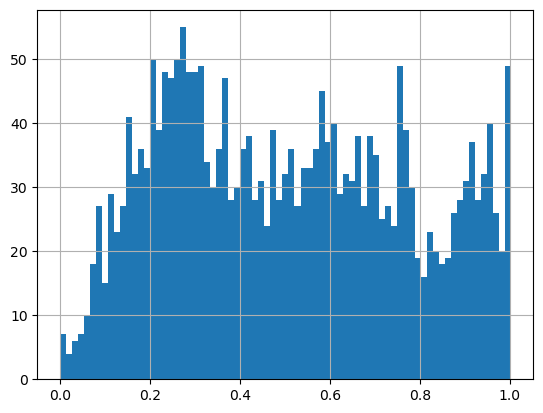

In [97]:
# what are the distributions of redshift for each true_class
mismatched_objects[mismatched_objects['predicted_class']==2]['redshift'].hist(bins=75)  


<Axes: >

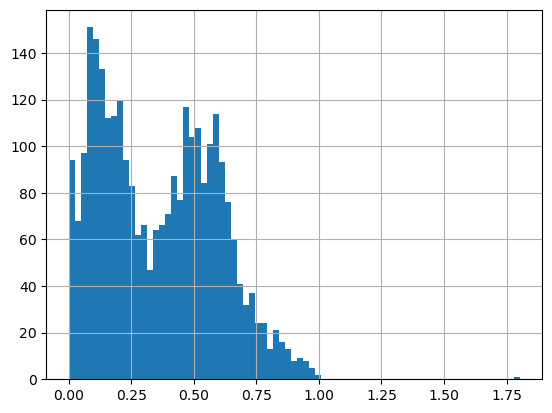

In [98]:
mismatched_objects[mismatched_objects['predicted_class']==0]['redshift'].hist(bins=75)

<Axes: >

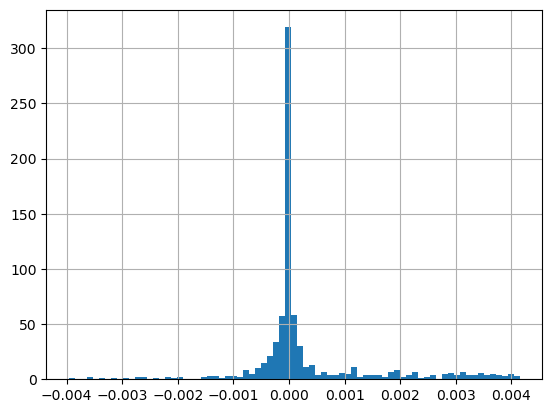

In [99]:
mismatched_objects[mismatched_objects['predicted_class']==1]['redshift'].hist(bins=75)

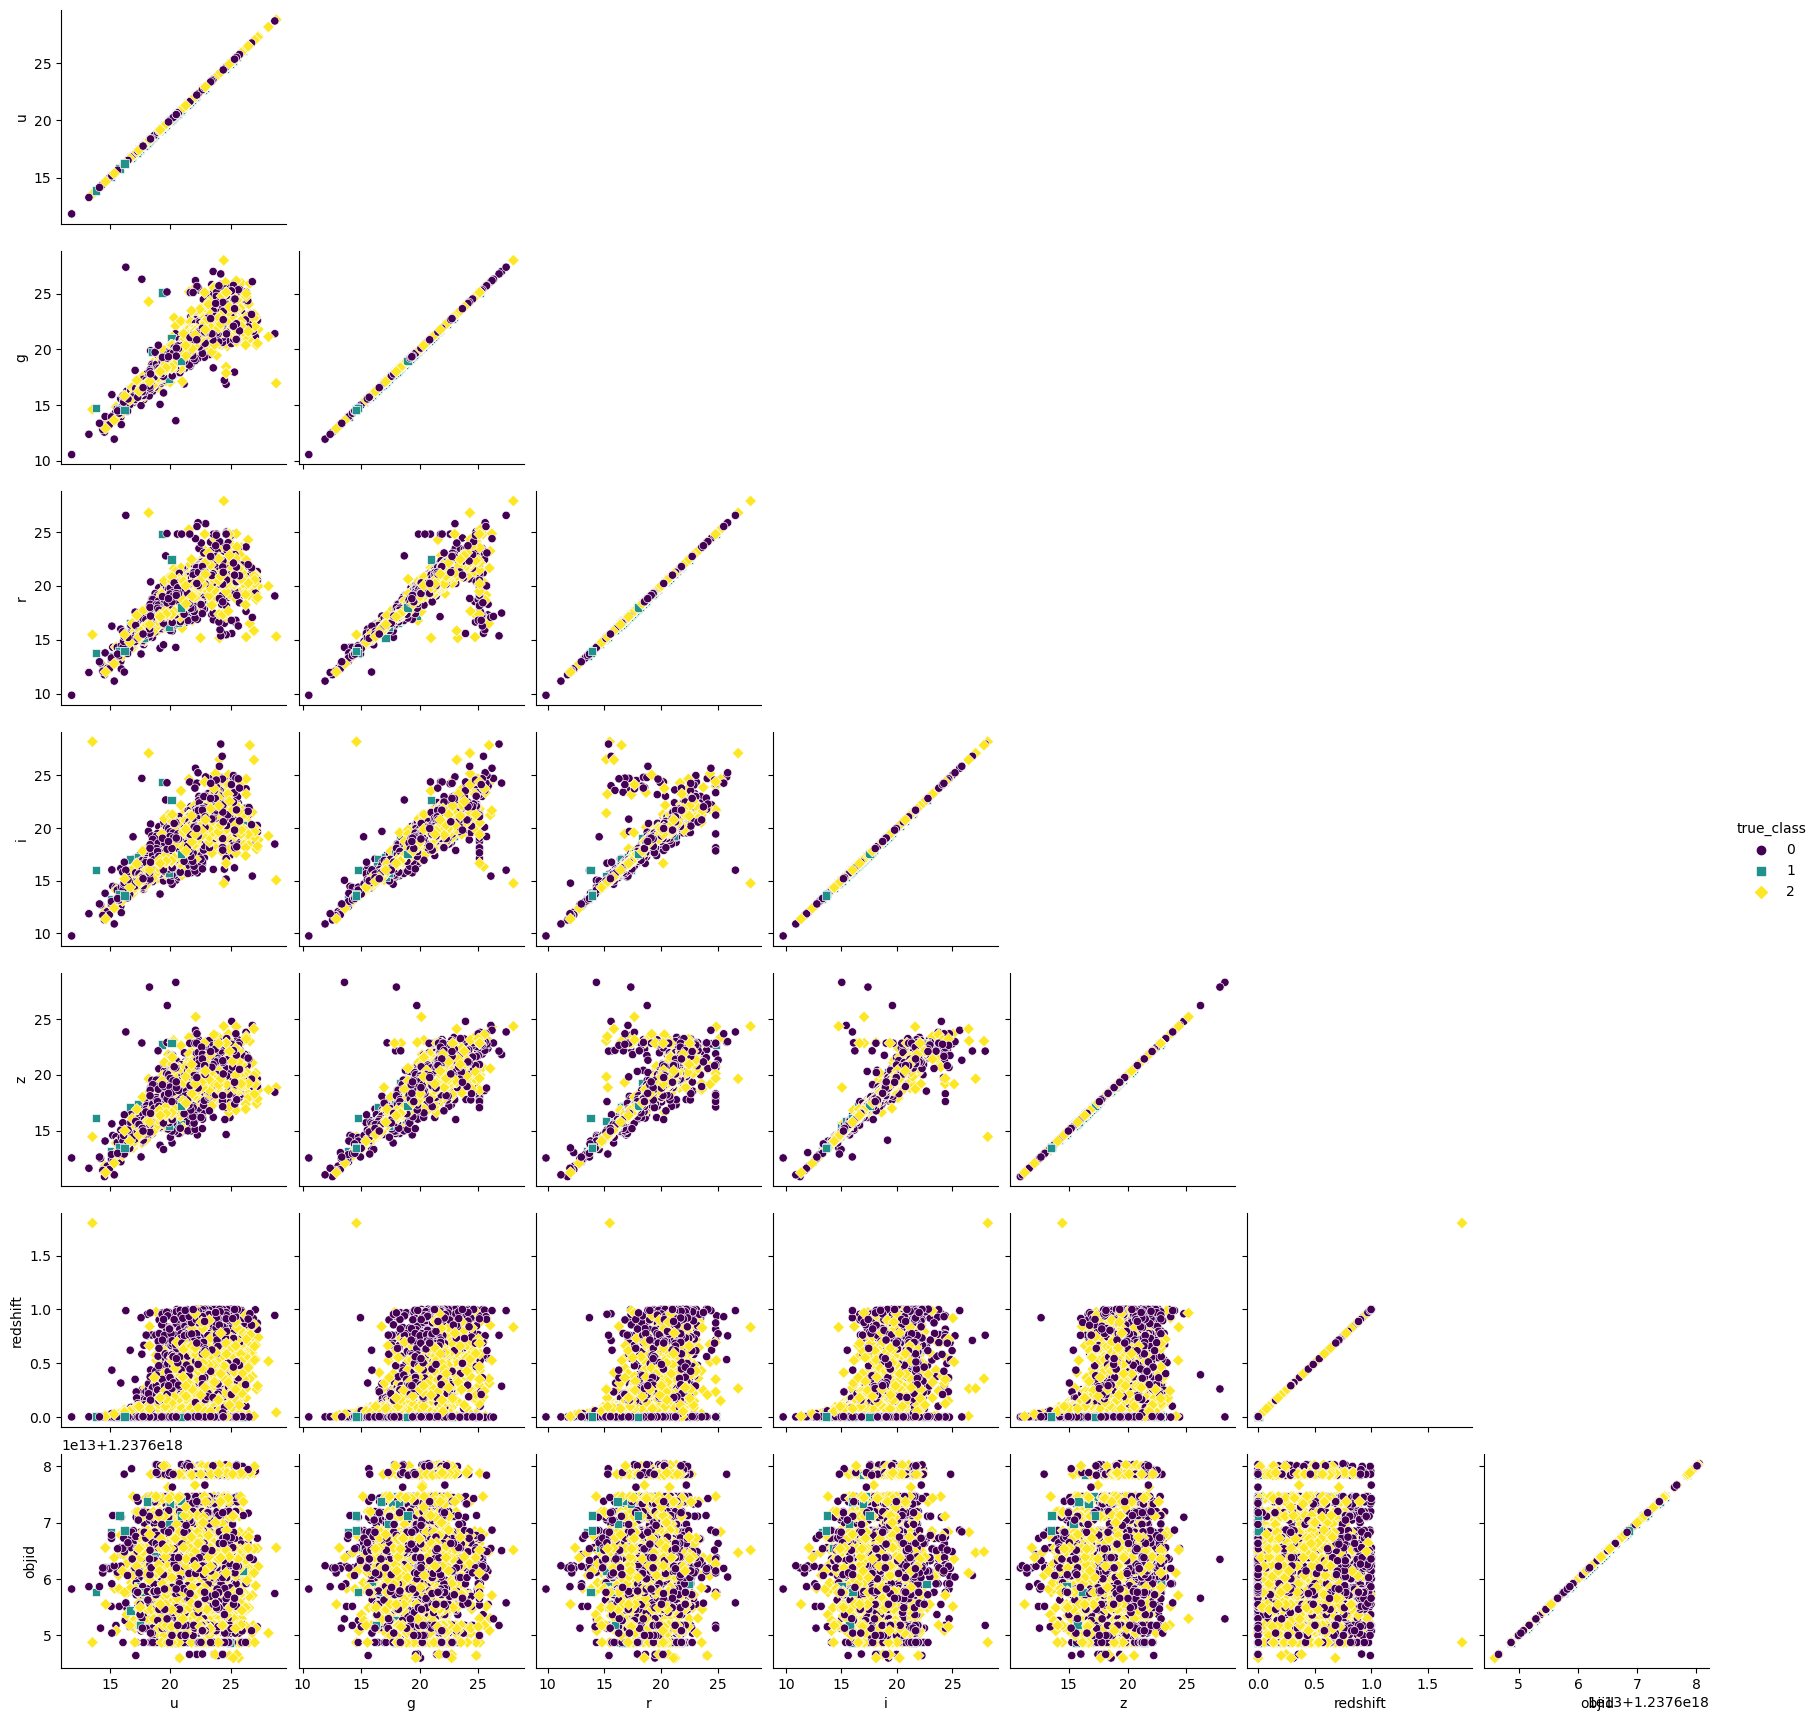

In [100]:
sns.pairplot(mismatched_objects.drop(columns = ['predicted_class']), hue='true_class', palette='viridis',markers=["o", "s", "D"],
         corner=True,diag_kind=None,)
plt.savefig('imgs/pairplot.png')

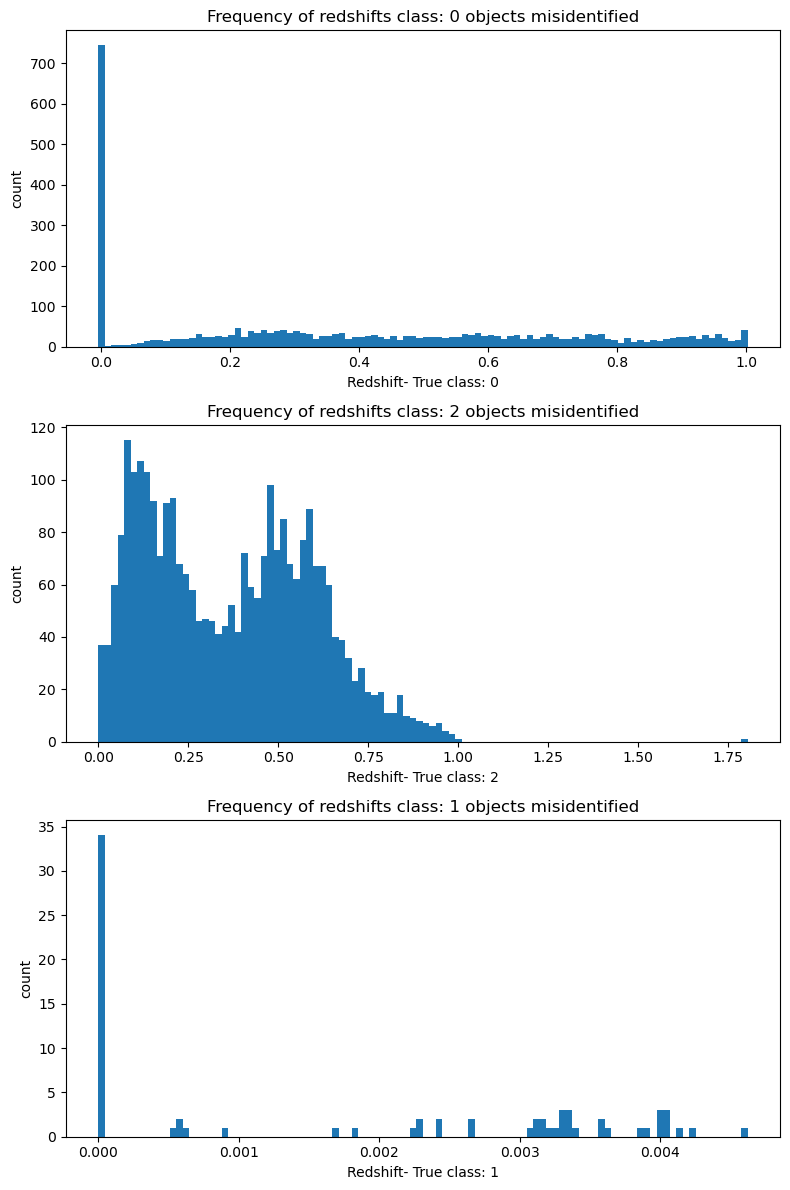

In [101]:
unique_classes = mismatched_objects['true_class'].unique()
fig, axes = plt.subplots(len(unique_classes), 1, figsize=(8, 4 * len(unique_classes)))

# Iterate over unique classes and create subplots
for i, class_label in enumerate(unique_classes):
    class_data = mismatched_objects[mismatched_objects['true_class'] == class_label]
    
    # Assuming 'feature1' and 'feature2' are the columns you want to visualize
    axes[i].hist(class_data['redshift'], label=class_label, bins = 100)
    axes[i].set_title(f'Frequency of redshifts class: {class_label} objects misidentified')
    axes[i].set_xlabel(f'Redshift- True class: {class_label}')
    axes[i].set_ylabel('count')
    

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('imgs/misclass_hists.png')
plt.show()


In [102]:
mismatched_objects.describe()

,u,g,r,i,z,redshift,objid,predicted_class,true_class
count,5981.000000,5981.000000,5981.000000,5981.000000,5981.000000,5981.000000,5.981000e+03,5981.000000,5981.000000
mean,21.610898,20.368504,19.501905,19.058123,18.789298,0.373310,1.237662e+18,0.914897,0.953352
std,2.195411,2.016748,1.938754,1.961519,1.956980,0.281460,7.353120e+12,0.929962,0.992614
min,11.824290,10.537220,9.852757,9.755538,10.884210,-0.003960,1.237646e+18,0.000000,0.000000
25%,19.969480,18.948510,18.108070,17.755440,17.495560,0.127873,1.237657e+18,0.000000,0.000000
50%,21.836280,20.848190,19.975680,19.369650,19.030230,0.345918,1.237662e+18,1.000000,0.000000
75%,23.092530,21.784750,20.858260,20.222380,20.005640,0.586605,1.237666e+18,2.000000,2.000000
max,28.787190,28.015510,27.875120,28.182330,28.272030,1.803164,1.237680e+18,2.000000,2.000000


In [111]:
# I want to look at the misclassified objects using the SDSS image viewer https://skyserver.sdss.org/dr9/en/tools/quicklook/quickobj.asp
mismatched_objects[(mismatched_objects['predicted_class']==0) & (mismatched_objects['true_class']==2)].sample(10)[''daffgadfgadfg              ]

,u,g,r,i,z,redshift,objid,predicted_class,true_class
5932,22.31379,21.02710,19.95570,19.37295,19.00693,0.469866,1237666299481358860,0,2
5137,20.28101,18.94647,18.02308,17.52993,17.29127,0.217922,1237656242772377899,0,2
3816,23.04274,22.72363,21.22966,19.99417,19.63754,0.733184,1237666407361806848,0,2
879,19.75197,18.99104,18.37345,18.01693,17.76445,0.251961,1237655126094250149,0,2
4311,22.07137,21.25049,20.00299,19.00744,18.61580,0.594841,1237678618502562220,0,2
3674,22.21094,21.39213,20.42366,19.70771,19.11958,0.344396,1237663530794746626,0,2
5146,24.63440,21.89157,21.21261,21.08730,21.07582,0.247498,1237664835924328643,0,2
2849,23.91289,21.86898,20.48528,19.66305,19.19062,0.796581,1237673755496483978,0,2
1029,23.04527,20.64092,19.54840,18.94178,18.45362,0.735530,1237667540678607105,0,2
5669,23.97077,21.01995,19.89005,19.11223,18.68869,0.434837,1237663916263146103,0,2


In [109]:
mismatched_objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981 entries, 0 to 5980
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   u                5981 non-null   float64
 1   g                5981 non-null   float64
 2   r                5981 non-null   float64
 3   i                5981 non-null   float64
 4   z                5981 non-null   float64
 5   redshift         5981 non-null   float64
 6   objid            5981 non-null   int64  
 7   predicted_class  5981 non-null   int64  
 8   true_class       5981 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 420.7 KB


In [105]:
# news recently was about a quasar mistaken for a star.
notqso = mismatched_objects[(mismatched_objects['predicted_class']==2) & (mismatched_objects['true_class']==1)]
notqso

,u,g,r,i,z,redshift,objid,predicted_class,true_class
694,20.26854,17.88275,17.31698,15.98298,15.52792,0.000560,1237651754530767040,2,1
3071,20.46497,17.99243,16.59621,15.99332,15.63349,0.000604,1237648722304368818,2,1
3508,20.08419,17.69473,16.51339,15.97006,15.64671,0.000549,1237673474174550211,2,1
4344,20.59518,18.11124,16.60795,15.83732,15.39903,0.000558,1237657629514989798,2,1
4617,20.87536,18.31213,16.78951,16.01258,15.56144,0.000879,1237673808653910478,2,1


### Here are 'stars' miclassified by my model as Quasars